This notebook aims to predict blood pressure using bioimpedance measurements from graphene electronic tattoos.

For more detail and access to the data read this [article](https://physicsworld.com/a/graphene-tattoo-provides-cuffless-blood-pressure-monitoring/).

### **1. Data Exploration and Preprocessing**

### **1.1 Creating a combined dataset from the CSVs**

The goal of this section is to combine all of the CSVs into one pandas dataframe with the following schema:

***Subject, SetupType, Setup Trial, Time, Bioz, FinapresBP, FinapresPPG, PPG***

In [1]:
import pandas as pd
import os 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

>##### **Lets start by reading the data related to one patient and setup.**

In [2]:
# The path to the setup results
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0/subject1_day1/setup01_baseline"

csv_files = glob.glob(os.path.join(path, "*.csv")) 

# A list to collect DataFrames
dfs = []

# Loop over the list of csv files 
for f in csv_files: 

    # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
    f = f.replace("\\", "/")

    # Extract the trial, setup and subject info from the file path
    trial_string = f.split("/")[-1]
    setup_string = f.split("/")[-2]
    subject_string = f.split("/")[-3]

    # Process the strings into keys
    trial = int(trial_string.split('_')[1].replace('trial', ''))
    setup_type = setup_string.split('_')[1]  # Include the type of experiment done

    # Read the csv file and add the ids used to identify the experiment
    next_df = pd.read_csv(f)
    next_df['Subject'] = subject_string
    next_df['SetupType'] = setup_type
    next_df['Setup'] = setup_string
    next_df['Trial'] = trial  # Should be shared across files from the same trial

    dfs.append(next_df)

# Concatenate the dataframes into one
df = pd.concat(dfs, ignore_index=True)

df

,time,FinapresPPG,Subject,SetupType,Setup,Trial,FinapresBP,BioZ1,BioZ2,BioZ3,BioZ4,PPG
0,2.006923,22.53055,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN,NaN,NaN
1,2.020257,18.95704,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN,NaN,NaN
2,2.033590,15.40484,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN,NaN,NaN
3,2.046923,11.93870,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN,NaN,NaN
4,2.060257,8.67134,subject1_day1,baseline,setup01_baseline,2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
479524,86.541795,17.34067,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN,NaN,NaN
479525,86.555128,15.72045,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN,NaN,NaN
479526,86.568461,14.10483,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN,NaN,NaN
479527,86.581795,12.27887,subject1_day1,baseline,setup01_baseline,1,NaN,NaN,NaN,NaN,NaN,NaN


Unfortunately, values from the same experiment at the same time are on different rows.

To resolve this Group By the id columns and aggregate.

Now each row should represent a metric at a specific time, providied the metric was gathered at that interval.

In [3]:
df = df.groupby(['Subject', 'SetupType', 'Setup', 'Trial', 'time']).agg('mean').reset_index()

> ##### **An overview of the current dataset.**

In [4]:
# Set the Seaborn Style
sns.set_style("whitegrid")

In [5]:
display(df)
df.info()
df.describe()

,Subject,SetupType,Setup,Trial,time,FinapresPPG,FinapresBP,BioZ1,BioZ2,BioZ3,BioZ4,PPG
0,subject1_day1,baseline,setup01_baseline,1,1.000021,NaN,NaN,45.11402,18.60437,20.92109,6.67912,12.85023
1,subject1_day1,baseline,setup01_baseline,1,1.000821,NaN,NaN,45.19330,18.60317,20.84464,6.61070,12.72152
2,subject1_day1,baseline,setup01_baseline,1,1.001621,NaN,NaN,45.27085,18.60096,20.76674,6.54201,12.59401
3,subject1_day1,baseline,setup01_baseline,1,1.002421,NaN,NaN,45.34667,18.59775,20.68740,6.47308,12.46770
4,subject1_day1,baseline,setup01_baseline,1,1.003221,NaN,NaN,45.42077,18.59353,20.60664,6.40395,12.34258
...,...,...,...,...,...,...,...,...,...,...,...,...
263024,subject1_day1,baseline,setup01_baseline,2,87.596021,NaN,NaN,35.90495,12.90030,8.22138,5.59188,-0.13551
263025,subject1_day1,baseline,setup01_baseline,2,87.596821,NaN,NaN,36.05002,12.96404,8.24659,5.66730,-0.14933
263026,subject1_day1,baseline,setup01_baseline,2,87.597621,NaN,NaN,36.19220,13.02675,8.27244,5.74181,-0.16312
263027,subject1_day1,baseline,setup01_baseline,2,87.598421,NaN,NaN,36.33149,13.08843,8.29893,5.81538,-0.17685


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263029 entries, 0 to 263028
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Subject      263029 non-null  object 
 1   SetupType    263029 non-null  object 
 2   Setup        263029 non-null  object 
 3   Trial        263029 non-null  int64  
 4   time         263029 non-null  float64
 5   FinapresPPG  12690 non-null   float64
 6   FinapresBP   33839 non-null   float64
 7   BioZ1        216500 non-null  float64
 8   BioZ2        216500 non-null  float64
 9   BioZ3        216500 non-null  float64
 10  BioZ4        216500 non-null  float64
 11  PPG          216500 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 24.1+ MB


,Trial,time,FinapresPPG,FinapresBP,BioZ1,BioZ2,BioZ3,BioZ4,PPG
count,263029.000000,263029.000000,12690.000000,33839.000000,216500.000000,216500.000000,216500.000000,216500.000000,216500.000000
mean,1.499998,44.299634,3.118297,100.468637,25.550801,9.075036,10.228314,3.341454,0.385717
std,0.500001,24.898066,22.660160,14.259206,42.981838,15.749782,15.668690,5.928609,1.396737
min,1.000000,1.000021,-43.664880,70.307840,-84.635750,-31.683900,-40.261580,-15.341980,-4.128240
25%,1.000000,22.740021,-17.135990,88.941565,-3.573203,-1.582795,-0.110363,-0.917353,-0.766235
50%,1.000000,44.300021,2.623510,98.811970,39.825125,14.179090,11.960885,4.429660,0.558550
75%,2.000000,65.859923,22.002902,111.115920,60.602902,21.819870,20.173572,7.746480,1.524820
max,2.000000,87.599221,59.005310,136.984660,94.314210,38.766850,62.628790,18.657800,12.850230


In [10]:
df[df['FinapresBP'].notna()]

,Subject,SetupType,Setup,Trial,time,FinapresPPG,FinapresBP,BioZ1,BioZ2,BioZ3,BioZ4,PPG
1252,subject1_day1,baseline,setup01_baseline,1,2.000961,NaN,117.25990,NaN,NaN,NaN,NaN,NaN
1259,subject1_day1,baseline,setup01_baseline,1,2.005961,NaN,116.50575,NaN,NaN,NaN,NaN,NaN
1267,subject1_day1,baseline,setup01_baseline,1,2.010961,NaN,115.71514,NaN,NaN,NaN,NaN,NaN
1274,subject1_day1,baseline,setup01_baseline,1,2.015961,NaN,114.89302,NaN,NaN,NaN,NaN,NaN
1282,subject1_day1,baseline,setup01_baseline,1,2.020961,NaN,114.04378,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
261741,subject1_day1,baseline,setup01_baseline,2,86.574923,NaN,119.63236,NaN,NaN,NaN,NaN,NaN
261748,subject1_day1,baseline,setup01_baseline,2,86.579923,NaN,120.48830,NaN,NaN,NaN,NaN,NaN
261757,subject1_day1,baseline,setup01_baseline,2,86.584923,NaN,121.17915,NaN,NaN,NaN,NaN,NaN
261764,subject1_day1,baseline,setup01_baseline,2,86.589923,NaN,121.71462,NaN,NaN,NaN,NaN,NaN


Show the correlation matrix of each of the variables.

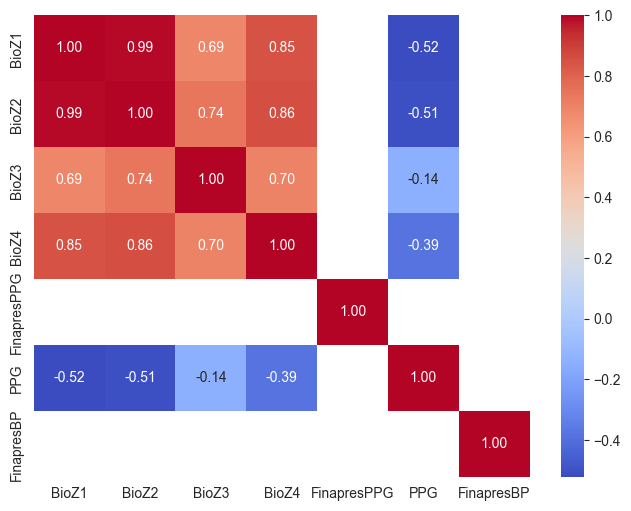

In [7]:
correlation_matrix = df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresPPG', 'PPG', 'FinapresBP']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

I'll visualise one trial to get an understanding of the data.

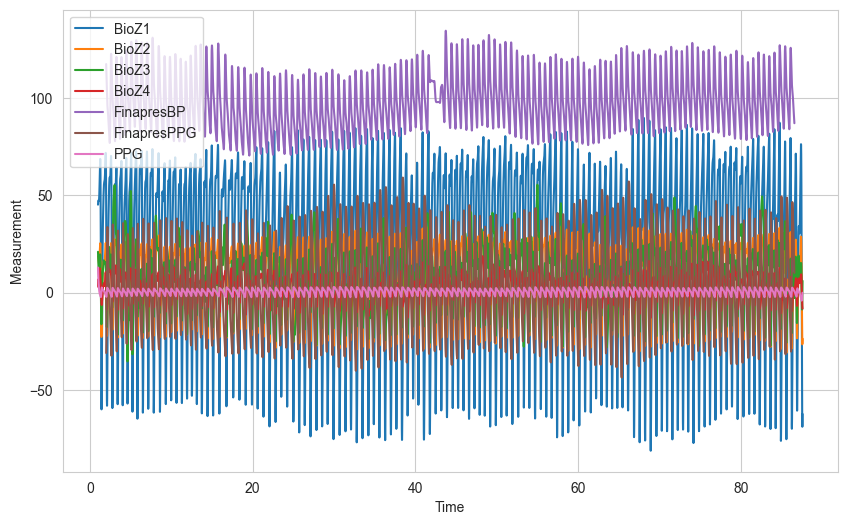

In [8]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP', 'FinapresPPG', 'PPG']

trial1_df = df[df['Trial'] == 1]
# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=trial1_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()

plt.show()

It's a bit of a mess. For more detail I'll limit it to a 5 second stretch

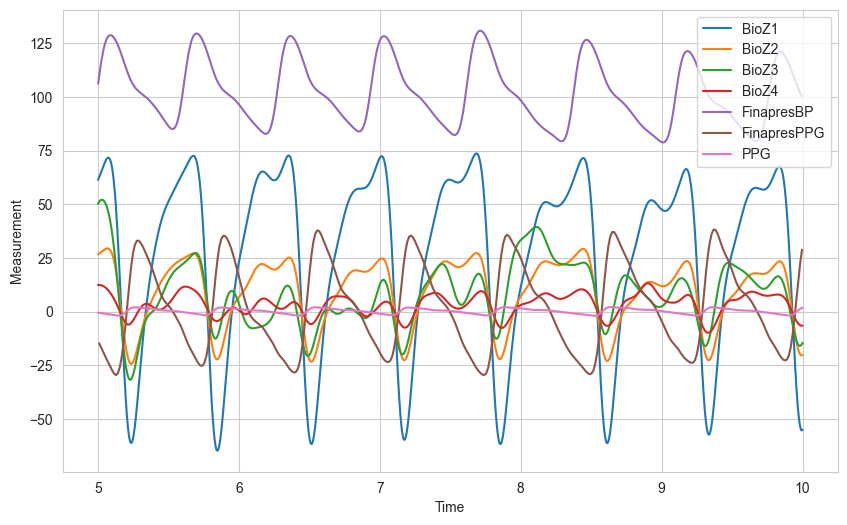

In [9]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresBP', 'FinapresPPG', 'PPG']

# Filter the DataFrame by time
plot_df = trial1_df[(trial1_df['time'] >= 5) & (trial1_df['time'] <= 10)]

# Create the plot
plt.figure(figsize=(10, 6))

for column in columns_to_plot:
    sns.lineplot(data=plot_df, x='time', y=column, label=column)

plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.show()

Lets plot each Measurement directly against Blood Pressure.

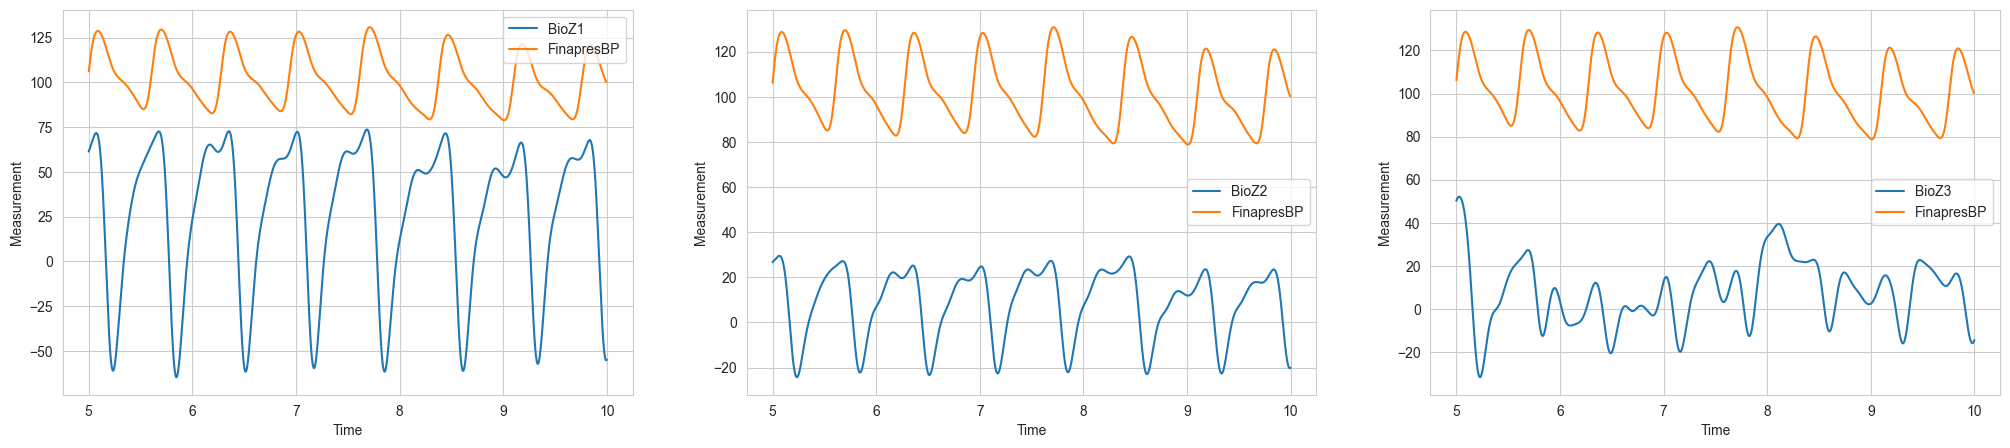

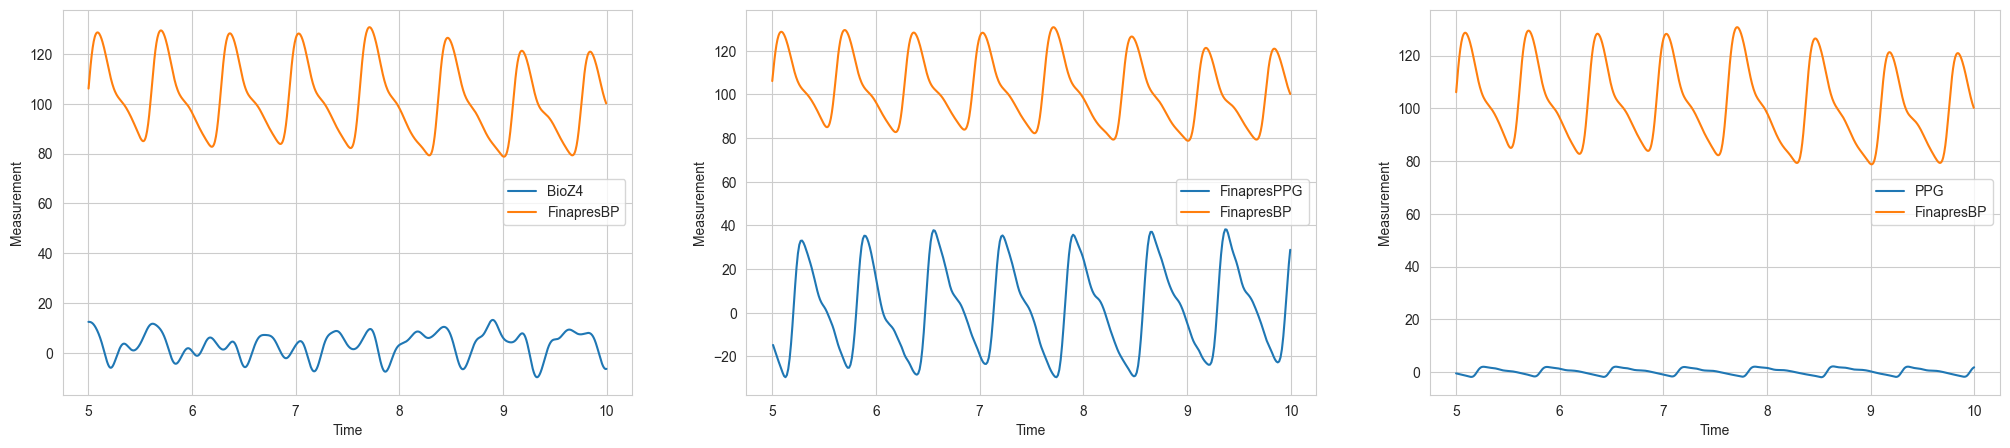

In [28]:
# Define the columns to plot
columns_to_plot = ['BioZ1', 'BioZ2', 'BioZ3']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(25, 5))

for ax, column in zip(axs, columns_to_plot):
    sns.lineplot(data=plot_df, x='time', y=column, label=column, ax=ax)
    sns.lineplot(data=plot_df, x='time', y='FinapresBP', label='FinapresBP', ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Measurement')
    ax.legend()

plt.show()

columns_to_plot = ['BioZ4', 'FinapresPPG', 'PPG']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns_to_plot), figsize=(25, 5))

for ax, column in zip(axs, columns_to_plot):
    sns.lineplot(data=plot_df, x='time', y=column, label=column, ax=ax)
    sns.lineplot(data=plot_df, x='time', y='FinapresBP', label='FinapresBP', ax=ax)
    ax.set_xlabel('Time')
    ax.set_ylabel('Measurement')
    ax.legend()

plt.show()

### **1.2 Engineer the Features from the Paper**

>##### **Extract the features from the paper**

First lets examine the blood pressure meaasurements.

In [29]:
blood_pressure_df = df[['Subject', 'SetupType', 'Setup', 'Trial', 'time', 'FinapresBP']].dropna(subset=['FinapresBP'])
blood_pressure_df

,Subject,SetupType,Setup,Trial,time,FinapresBP
1252,subject1_day1,baseline,setup01_baseline,1,2.000961,117.25990
1259,subject1_day1,baseline,setup01_baseline,1,2.005961,116.50575
1267,subject1_day1,baseline,setup01_baseline,1,2.010961,115.71514
1274,subject1_day1,baseline,setup01_baseline,1,2.015961,114.89302
1282,subject1_day1,baseline,setup01_baseline,1,2.020961,114.04378
...,...,...,...,...,...,...
261741,subject1_day1,baseline,setup01_baseline,2,86.574923,119.63236
261748,subject1_day1,baseline,setup01_baseline,2,86.579923,120.48830
261757,subject1_day1,baseline,setup01_baseline,2,86.584923,121.17915
261764,subject1_day1,baseline,setup01_baseline,2,86.589923,121.71462


In the paper they extract 4 points from each heartbeat.

1. ***diastolic peak***
2. ***maximum slope***
3. ***systolic foot (SYS)***
4. ***inflection point***

The ***diastolic peak*** and ***systolic foot*** can be found with the `find_peaks` function.

In [67]:
plot_df = blood_pressure_df[(blood_pressure_df['time'] >= 5) & (blood_pressure_df['time'] <= 10)]
plot_df = plot_df[plot_df['Trial'] == 1]

diastolic_peaks, _ = find_peaks(plot_df['FinapresBP'])

# Find the peaks of the inverse to get the troughs
systolic_foot, _ = find_peaks(-1 * plot_df['FinapresBP'])

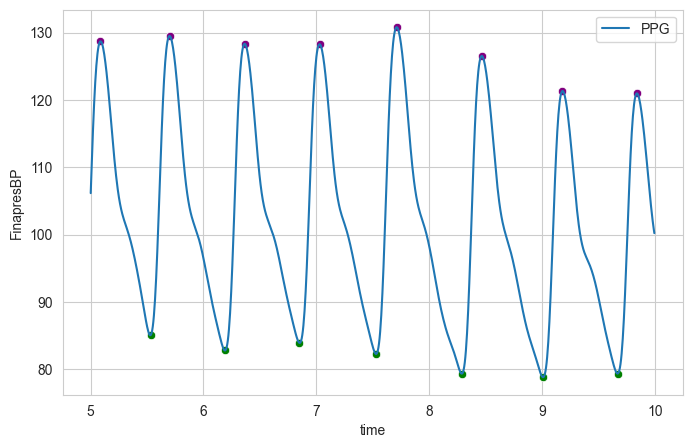

In [68]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=plot_df, x='time', y='FinapresBP', label=column)
sns.scatterplot(data=plot_df.iloc[diastolic_peaks], x="time", y="FinapresBP", color="purple")
sns.scatterplot(data=plot_df.iloc[systolic_foot], x="time", y="FinapresBP", color="green")
plt.show()

The ***maximum slope*** and ***inflection point*** require working with the derrivatives.

>##### **Now I'll repeat this with all of the CSVs**

In [22]:
# Create a list for the dataframes again
dfs = []

# Set this to the to the root folder of the data
path = "../../data/continuous-cuffless-monitoring-of-arterial-blood-pressure-via-graphene-bioimpedance-tattoos-1.0.0"

# Get all of the subject folders
subject_folders = glob.glob(os.path.join(path, "*" + os.sep))  # os.sep ensures that only directories are matched

# Iterate over each subject folder abd examine each setup folder
for subject_folder in subject_folders:
    setup_folders = glob.glob(os.path.join(subject_folder, "*" + os.sep))

    # Iterate over each setup folder adding the CSVs within
    for setup_folder in setup_folders:
        csv_files = glob.glob(os.path.join(setup_folder, "*.csv")) 

        # Loop over the list of csv files 
        for f in csv_files: 

            # To avoid issues caused by mixing Windows and Linux paths replace \\ with /
            f = f.replace("\\", "/")

            # Extract the trial, setup and subject info from the file path
            trial_string = f.split("/")[-1]
            setup_string = f.split("/")[-2]
            subject_string = f.split("/")[-3]

            # Process the strings into keys
            trial = int(trial_string.split('_')[1].replace('trial', ''))
            setup_type = setup_string.split('_')[1]  # Include the type of experiment done

            # Read the csv file and add the ids used to identify the experiment
            next_df = pd.read_csv(f)
            next_df['Subject'] = subject_string
            next_df['SetupType'] = setup_type
            next_df['Setup'] = setup_string
            next_df['Trial'] = trial  # Should be shared across files from the same trial

            dfs.append(next_df)

df = pd.concat(dfs, ignore_index=True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

Get each metric on 1 row again.

In [ ]:
#df = df.groupby(['Subject', 'SetupType', 'Setup', 'Trial', 'time']).agg('mean').reset_index()

An overview of the dataset.

In [ ]:
display(df)
df.info()
df.describe()

,time,FinapresBP,Subject,SetupType,Setup,Trial,BioZ1,BioZ2,BioZ3,BioZ4,PPG,FinapresPPG
0,2.001273,61.51059,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
1,2.006273,61.43445,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
2,2.011273,61.33912,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
3,2.016273,61.22310,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
4,2.021273,61.08539,subject4_day1,hgcp,setup03_hgcp,12,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
63191121,86.576755,139.61385,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN
63191122,86.581755,138.12162,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN
63191123,86.586755,136.61745,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN
63191124,86.591755,135.11783,subject1_day1,hgcp,setup07_hgcp,29,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63191126 entries, 0 to 63191125
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         float64
 1   FinapresBP   float64
 2   Subject      object 
 3   SetupType    object 
 4   Setup        object 
 5   Trial        int64  
 6   BioZ1        float64
 7   BioZ2        float64
 8   BioZ3        float64
 9   BioZ4        float64
 10  PPG          float64
 11  FinapresPPG  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 5.6+ GB


: 

We should double check that the data aligns with the folders and the descriptions in the README. 

In [ ]:
print(df['Subject'].unique(), "\n")
print(df['SetupType'].unique(), "\n")

Show the correlation matrix of each of the variables.

In [ ]:
correlation_matrix = df[['BioZ1', 'BioZ2', 'BioZ3', 'BioZ4', 'FinapresPPG', 'PPG', 'FinapresBP']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()